In [ ]:
!pip install -q kaggle
# This line fixes the 'TypeError' by installing a compatible library version
!pip install 'urllib3<2'

from google.colab import files
import os, zipfile

print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Correctly move the uploaded kaggle.json
# This handles the case if your file is named 'kaggle (1).json'
file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

!mkdir -p ~/.kaggle
!cp "{file_name}" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("\nDownloading dataset...")
!kaggle datasets download -d revatisn/cancer-benign-and-malignant -p /content/

# --- Fix: Remove any old/corrupted zip file before unzipping ---
zip_path = '/content/cancer-benign-and-malignant.zip'
extract_dir = '/content/Data'

if os.path.exists(zip_path):
    print("Unzipping file...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Dataset extracted to: {extract_dir}")
    except zipfile.BadZipFile:
        print("\n--- ERROR ---")
        print("BadZipFile error. This means the download failed.")
        print("Please check your Kaggle API key or internet connection and try re-running this cell.")
else:
    print(f"ERROR: {zip_path} not found. Download failed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Uploaded file: kaggle.json

Dataset URL: https://www.kaggle.com/datasets/revatisn/cancer-benign-and-malignant
License(s): MIT
100% 5.23G/5.23G [01:26<00:00, 46.8MB/s]
100% 5.23G/5.23G [01:26<00:00, 64.8MB/s]
Unzipping file...
✅ Dataset extracted to: /content/Data


In [ ]:
import os
import glob
import random
import math
import numpy as np  # Make sure numpy is imported
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score
)
from PIL import Image
from tqdm import tqdm
import time
import torch.nn.functional as F

# ===========================================================================
# CONFIGURATION
# ===========================================================================

# --- Verify the data path ---
# The zip file unzips 'Data/Benign' and 'Data/Malignant' into '/content/Data'
# So the correct root path is '/content/Data/Data'
BASE_DATA_DIR = '/content/Data/Data'

if not os.path.exists(os.path.join(BASE_DATA_DIR, 'Benign')):
    print(f"Warning: Path {BASE_DATA_DIR} not found.")
    alt_path = "/content/Data" # The folder from the zip file is 'Data'
    if os.path.exists(alt_path) and os.path.exists(os.path.join(alt_path, 'Benign')):
        print(f"Using alternative path: {alt_path}")
        BASE_DATA_DIR = alt_path
    else:
        raise FileNotFoundError(f"Could not find 'Benign' folder in {BASE_DATA_DIR} or {alt_path}. Please re-run the unzip cell.")
else:
    print(f"✅ Data root found: {BASE_DATA_DIR}")


CLASSES = ["Benign", "Malignant"]

# --- Model & Training Config ---
CONFIG = {
    "IMAGE_SIZE": 224, # Swin-Tiny model size
    "MODEL_NAME": "swin_tiny_patch4_window7_224",
    "BATCH_SIZE": 32,  # Batch size
    "EPOCHS": 20,      # Your requirement
    "LR": 1e-4,        # Learning Rate
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "RANDOM_STATE": 42
}

# Set random seeds for reproducibility
random.seed(CONFIG['RANDOM_STATE'])
np.random.seed(CONFIG['RANDOM_STATE'])
torch.manual_seed(CONFIG['RANDOM_STATE'])
if CONFIG['DEVICE'].type == 'cuda':
    torch.cuda.manual_seed(CONFIG['RANDOM_STATE'])

print(f"✅ Configuration set. Using device: {CONFIG['DEVICE']}")

✅ Data root found: /content/Data/Data
✅ Configuration set. Using device: cuda


In [ ]:
def gather_filepaths_by_class(root, classes):
    """Finds all image files and matches them with labels."""
    filepaths, labels = [], []
    print("Gathering file paths...")
    for cls in classes:
        cls_root = os.path.join(root, cls)
        # Use recursive glob to find all images in subfolders (a, b, c, etc.)
        patterns = ["**/*.png", "**/*.jpg", "**/*.jpeg", "**/*.bmp"]
        cls_files = []
        for pat in patterns:
            cls_files.extend(glob.glob(os.path.join(cls_root, pat), recursive=True))

        cls_labels = [cls] * len(cls_files)
        filepaths.extend(cls_files)
        labels.extend(cls_labels)
    print(f"✅ Total images found: {len(filepaths)}")
    return filepaths, labels

# --- 1. Gather all files ---
filepaths, labels = gather_filepaths_by_class(BASE_DATA_DIR, CLASSES)
print(f"Benign: {labels.count('Benign')} | Malignant: {labels.count('Malignant')}")

# --- 2. Create stratified splits (70% train, 15% val, 15% test) ---
# First split: 70% train, 30% temp (val+test)
train_fps, temp_fps, train_labels, temp_labels = train_test_split(
    filepaths, labels,
    test_size=0.30,
    random_state=CONFIG['RANDOM_STATE'],
    stratify=labels
)

# Second split: 15% val, 15% test (split the 30% temp set in half)
val_fps, test_fps, val_labels, test_labels = train_test_split(
    temp_fps, temp_labels,
    test_size=0.50, # 50% of the 30% temp set = 15% of total
    random_state=CONFIG['RANDOM_STATE'],
    stratify=temp_labels
)

print(f"Training:   {len(train_fps)} images")
print(f"Validation: {len(val_fps)} images")
print(f"Test:       {len(test_fps)} images")

Gathering file paths...
✅ Total images found: 65002
Benign: 25001 | Malignant: 40001
Training:   45501 images
Validation: 9750 images
Test:       9751 images


In [ ]:
class CancerDataset(Dataset):
    def __init__(self, filepaths, labels, image_size):
        self.filepaths = filepaths
        # Convert string labels to binary (0 = Benign, 1 = Malignant)
        self.labels = [0 if l.lower()=="benign" else 1 for l in labels]

        # --- Define transformations ---
        # Add ImageNet normalization, which Swin models expect
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        try:
            # Open image and ensure it's in RGB format
            img = Image.open(self.filepaths[idx]).convert("RGB")
            image_tensor = self.transform(img)
            label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
            return image_tensor, label_tensor
        except Exception as e:
            # This handles any corrupted images
            print(f"Warning: Skipping corrupted image {self.filepaths[idx]}: {e}")
            return None # We will filter these out in the dataloader

def collate_fn(batch):
    """Custom collate function to filter out None (corrupted) images."""
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

# --- Create Datasets ---
train_dataset = CancerDataset(train_fps, train_labels, CONFIG['IMAGE_SIZE'])
val_dataset = CancerDataset(val_fps, val_labels, CONFIG['IMAGE_SIZE'])
test_dataset = CancerDataset(test_fps, test_labels, CONFIG['IMAGE_SIZE'])

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=2, # Use 2 workers in Colab for faster loading
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"✅ DataLoaders ready! (train_loader, val_loader, test_loader are now defined)")

✅ DataLoaders ready! (train_loader, val_loader, test_loader are now defined)


In [ ]:
!pip install -q timm

import timm
import torch.nn as nn

device = CONFIG['DEVICE']

# Use tiny Swin Transformer (light but accurate)
model = timm.create_model(
    CONFIG['MODEL_NAME'],
    pretrained=True,
    num_classes=2  # Output 2 logits (for Benign and Malignant)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LR'])

print(f"✅ Swin Transformer model ({CONFIG['MODEL_NAME']}) ready on: {device}")

✅ Swin Transformer model (swin_tiny_patch4_window7_224) ready on: cuda


In [ ]:
print("=" * 70)
print(f"Starting training for {CONFIG['EPOCHS']} epochs...")
print("=" * 70)

best_val_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(CONFIG['EPOCHS']):
    start_time = time.time()

    # --- Training Phase ---
    model.train()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Train]"):
        # Skip empty batches (from collate_fn)
        if imgs.shape[0] == 0:
            continue

        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs) # Model outputs raw logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_preds / total_samples
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    running_loss, correct_preds, total_samples = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']} [Val]  "):
            if imgs.shape[0] == 0:
                continue

            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

    epoch_val_loss = running_loss / total_samples
    epoch_val_acc = correct_preds / total_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    end_time = time.time()

    print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} - Time: {end_time-start_time:.0f}s - "
          f"Train Loss: {epoch_train_loss:.4f} - Train Acc: {epoch_train_acc:.4f} - "
          f"Val Loss: {epoch_val_loss:.4f} - Val Acc: {epoch_val_acc:.4f}")

    # Save the best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_swin_model.pth')
        print(f"✨ New best model saved with Val Acc: {best_val_acc:.4f}")

print("\n✅ Training complete!")

Starting training for 20 epochs...


Epoch 1/20 [Val]  : 100%|██████████| 305/305 [01:04<00:00,  4.75it/s]


Epoch 1/20 - Time: 621s - Train Loss: 0.0837 - Train Acc: 0.9647 - Val Loss: 0.0306 - Val Acc: 0.9873
✨ New best model saved with Val Acc: 0.9873


Epoch 2/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.20it/s]


Epoch 2/20 - Time: 609s - Train Loss: 0.0386 - Train Acc: 0.9847 - Val Loss: 0.0385 - Val Acc: 0.9829


Epoch 3/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.30it/s]


Epoch 3/20 - Time: 608s - Train Loss: 0.0302 - Train Acc: 0.9889 - Val Loss: 0.0204 - Val Acc: 0.9919
✨ New best model saved with Val Acc: 0.9919


Epoch 4/20 [Val]  : 100%|██████████| 305/305 [00:59<00:00,  5.16it/s]


Epoch 4/20 - Time: 610s - Train Loss: 0.0224 - Train Acc: 0.9920 - Val Loss: 0.0200 - Val Acc: 0.9923
✨ New best model saved with Val Acc: 0.9923


Epoch 5/20 [Val]  : 100%|██████████| 305/305 [00:59<00:00,  5.15it/s]


Epoch 5/20 - Time: 610s - Train Loss: 0.0199 - Train Acc: 0.9933 - Val Loss: 0.0137 - Val Acc: 0.9952
✨ New best model saved with Val Acc: 0.9952


Epoch 6/20 [Val]  : 100%|██████████| 305/305 [00:59<00:00,  5.16it/s]


Epoch 6/20 - Time: 610s - Train Loss: 0.0214 - Train Acc: 0.9927 - Val Loss: 0.0182 - Val Acc: 0.9930


Epoch 7/20 [Val]  : 100%|██████████| 305/305 [00:59<00:00,  5.16it/s]


Epoch 7/20 - Time: 610s - Train Loss: 0.0141 - Train Acc: 0.9953 - Val Loss: 0.0162 - Val Acc: 0.9945


Epoch 8/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.25it/s]


Epoch 8/20 - Time: 609s - Train Loss: 0.0134 - Train Acc: 0.9957 - Val Loss: 0.0292 - Val Acc: 0.9905


Epoch 9/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.18it/s]


Epoch 9/20 - Time: 610s - Train Loss: 0.0146 - Train Acc: 0.9953 - Val Loss: 0.0172 - Val Acc: 0.9927


Epoch 10/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.19it/s]


Epoch 10/20 - Time: 610s - Train Loss: 0.0101 - Train Acc: 0.9964 - Val Loss: 0.0179 - Val Acc: 0.9933


Epoch 11/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.32it/s]


Epoch 11/20 - Time: 608s - Train Loss: 0.0130 - Train Acc: 0.9958 - Val Loss: 0.0115 - Val Acc: 0.9952


Epoch 12/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.19it/s]


Epoch 12/20 - Time: 610s - Train Loss: 0.0090 - Train Acc: 0.9971 - Val Loss: 0.0133 - Val Acc: 0.9953
✨ New best model saved with Val Acc: 0.9953


Epoch 13/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.30it/s]


Epoch 13/20 - Time: 607s - Train Loss: 0.0102 - Train Acc: 0.9968 - Val Loss: 0.0221 - Val Acc: 0.9931


Epoch 14/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.29it/s]


Epoch 14/20 - Time: 608s - Train Loss: 0.0108 - Train Acc: 0.9966 - Val Loss: 0.0161 - Val Acc: 0.9948


Epoch 15/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.25it/s]


Epoch 15/20 - Time: 608s - Train Loss: 0.0105 - Train Acc: 0.9969 - Val Loss: 0.0172 - Val Acc: 0.9953


Epoch 16/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.31it/s]


Epoch 16/20 - Time: 607s - Train Loss: 0.0095 - Train Acc: 0.9973 - Val Loss: 0.0154 - Val Acc: 0.9947


Epoch 17/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.28it/s]


Epoch 17/20 - Time: 608s - Train Loss: 0.0063 - Train Acc: 0.9982 - Val Loss: 0.0266 - Val Acc: 0.9938


Epoch 18/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.35it/s]


Epoch 18/20 - Time: 607s - Train Loss: 0.0071 - Train Acc: 0.9975 - Val Loss: 0.0163 - Val Acc: 0.9952


Epoch 19/20 [Val]  : 100%|██████████| 305/305 [00:57<00:00,  5.32it/s]


Epoch 19/20 - Time: 607s - Train Loss: 0.0088 - Train Acc: 0.9973 - Val Loss: 0.0171 - Val Acc: 0.9950


Epoch 20/20 [Val]  : 100%|██████████| 305/305 [00:58<00:00,  5.22it/s]

Epoch 20/20 - Time: 608s - Train Loss: 0.0081 - Train Acc: 0.9975 - Val Loss: 0.0363 - Val Acc: 0.9888

✅ Training complete!


In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('best_swin_model.pth'))
model.eval()

all_preds_classes, all_labels, all_preds_probs = [], [], []

print("\n" + "="*70)
print("Running evaluation on the Test Set...")
print("=" * 70)

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        if imgs.shape[0] == 0:
            continue

        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        # Get probabilities for AUC
        # Apply softmax to logits and get probability for the positive class (class 1)
        probs = F.softmax(outputs, dim=1)
        all_preds_probs.extend(probs[:, 1].cpu().numpy())

        # Get predicted classes (for other metrics)
        _, preds = torch.max(outputs, 1)
        all_preds_classes.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Calculate all metrics ---
acc = accuracy_score(all_labels, all_preds_classes)
auc = roc_auc_score(all_labels, all_preds_probs)
cm = confusion_matrix(all_labels, all_preds_classes)
# Note: 'pos_label=1' assumes 'Malignant' is the positive class.
precision = precision_score(all_labels, all_preds_classes, pos_label=1)
recall = recall_score(all_labels, all_preds_classes, pos_label=1)
f1 = f1_score(all_labels, all_preds_classes, pos_label=1)

print("\n" + "="*30)
print("✅ Evaluation complete.")
print("--- Test Set Metrics ---")
print(f"Accuracy:  {acc:.4f} (or {acc*100:.2f}%)")
print(f"AUC Score: {auc:.4f}")
print(f"Precision: {precision:.4f} (for Malignant)")
print(f"Recall:    {recall:.4f} (for Malignant)")
print(f"F1 Score:  {f1:.4f} (for Malignant)")
print("="*30 + "\n")

print("\nFull Classification Report:\n")
print(classification_report(all_labels, all_preds_classes, target_names=CLASSES))
print("\nConfusion Matrix:\n")
print(cm)


Running evaluation on the Test Set...


Evaluating: 100%|██████████| 305/305 [01:17<00:00,  3.92it/s]



✅ Evaluation complete.
--- Test Set Metrics ---
Accuracy:  0.9952 (or 99.52%)
AUC Score: 0.9996
Precision: 0.9958 (for Malignant)
Recall:    0.9963 (for Malignant)
F1 Score:  0.9961 (for Malignant)


Full Classification Report:

              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      3750
   Malignant       1.00      1.00      1.00      6001

    accuracy                           1.00      9751
   macro avg       0.99      0.99      0.99      9751
weighted avg       1.00      1.00      1.00      9751


Confusion Matrix:

[[3725   25]
 [  22 5979]]


GENERATING TRAINING VISUALIZATIONS


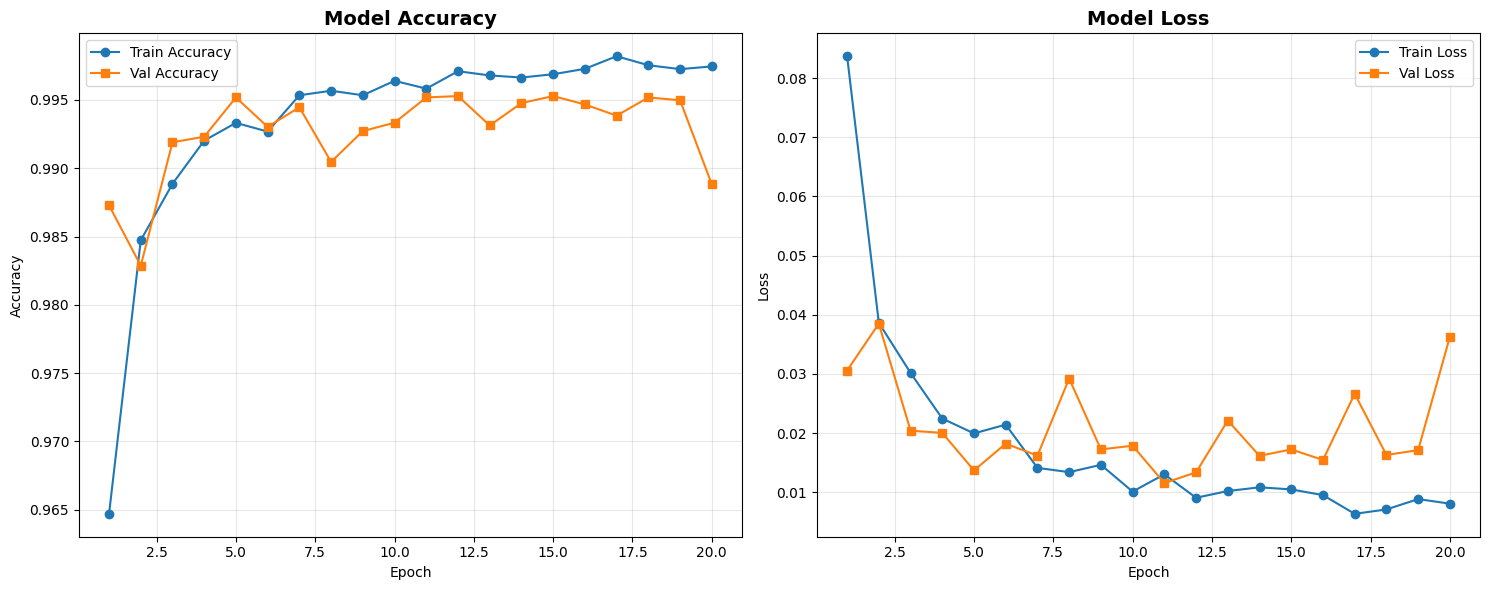


✓ Training history plot saved: 'swin_training_history.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 70)
print("GENERATING TRAINING VISUALIZATIONS")
print("=" * 70)

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Get the number of actual epochs run
    epochs_run = len(history['train_loss'])
    x_axis = range(1, epochs_run + 1)

    # Accuracy
    axes[0].plot(x_axis, history['train_acc'], label='Train Accuracy', marker='o')
    axes[0].plot(x_axis, history['val_acc'], label='Val Accuracy', marker='s')
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(x_axis, history['train_loss'], label='Train Loss', marker='o')
    axes[1].plot(x_axis, history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('swin_training_history.png', dpi=300, bbox_inches='tight')
    plt.show() # Show the plot directly in Colab
    print("\n✓ Training history plot saved: 'swin_training_history.png'")

# Call the function (history variable should exist from Cell 6)
try:
    plot_training_history(history)
except NameError:
    print("Error: 'history' variable not found. Please re-run Cell 6 (Training Loop).")


GENERATING EVALUATION VISUALIZATIONS


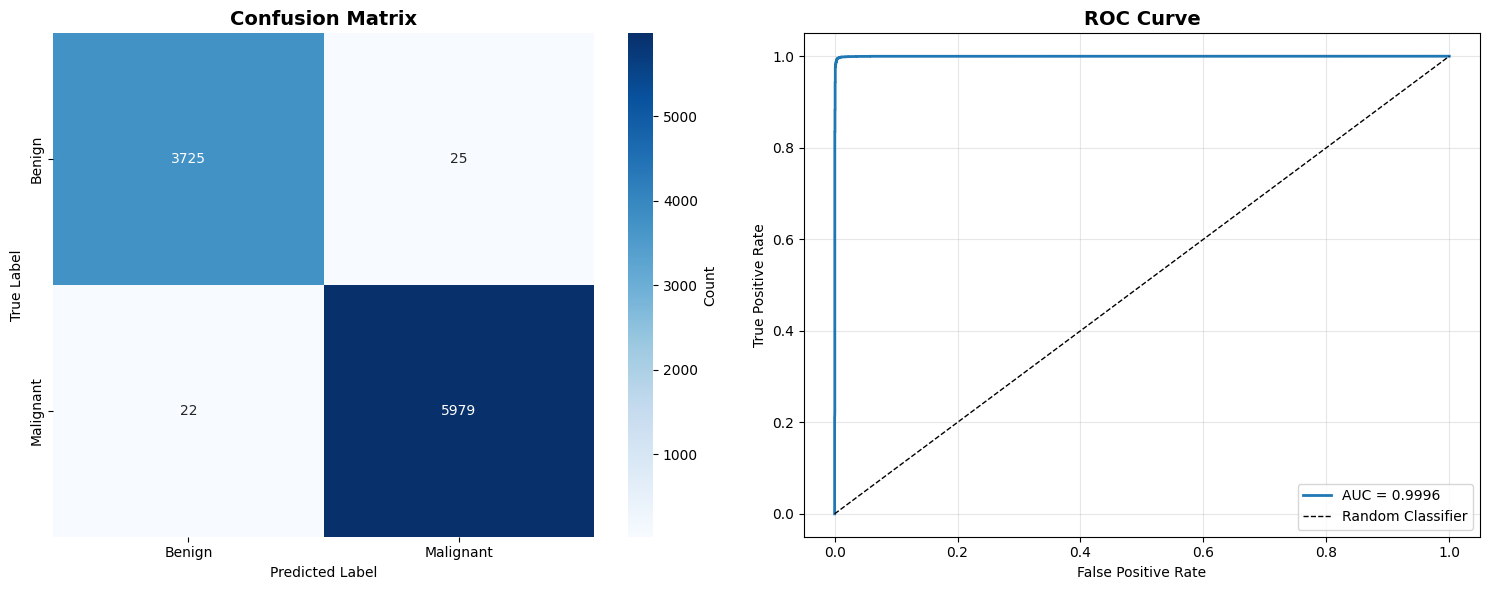

✓ Evaluation results plot saved: 'swin_evaluation_results.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

print("\n" + "=" * 70)
print("GENERATING EVALUATION VISUALIZATIONS")
print("=" * 70)

def plot_evaluation_results(cm, auc, y_true, y_pred_probs, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                ax=axes[0], cbar_kws={'label': 'Count'},
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    axes[1].plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.4f}")
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('swin_evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show() # Show the plot directly in Colab
    print("✓ Evaluation results plot saved: 'swin_evaluation_results.png'")

# Call the function (variables should exist from Cell 7)
try:
    # We use 'all_labels' and 'all_preds_probs' from Cell 7
    plot_evaluation_results(cm, auc, all_labels, all_preds_probs, CLASSES)
except NameError as e:
    print(f"Error: Could not plot results. Variable '{e.name}' not found.")
    print("Please re-run Cell 7 (Final Evaluation) to generate the metrics.")